# FoCus Dataset

In [1]:
DATASET = "FoCus"
SET = "train"           #train,   valid   

In [2]:
import pandas as pd
import json

with open(f'./datasets/{DATASET}/{SET}_focus.json') as f:
    data = json.load(f)

In [3]:
def convertToDialogue(my_list):
    formatted_string = ""
    for index, item in enumerate(my_list):
        if index % 2 == 0:
            user = "User1"
        else:
            user = "User2"
        formatted_string += f"{user}: {item}\n"
    formatted_string = formatted_string.rstrip("\n")
    return formatted_string

flattened_data = []
data_list = data['data']
for entry in data_list:
    persona =  "".join(entry['persona'])
    list_length = len(entry["utterance"])
    last_utterance = entry["utterance"][-1]
    dialogue_key = f"dialogue{list_length}"
    last_item = last_utterance[dialogue_key]
    flattened_data.append({
                'dialogID': entry['dialogID'],
                'persona': persona,
                'utterance': convertToDialogue(last_item)
            })

dataset = pd.DataFrame(flattened_data)
print(dataset.shape)

(12484, 3)


In [4]:
if SET == "train":
    # Randomly select 1500 rows
    df = dataset.sample(n=4000, random_state=42)
else:
    df = dataset

In [5]:
df = df.replace(r'\*\*', '', regex=True)
df = df.replace(r'\r', '', regex=True)
df = df.replace("'", "", regex=True)

df.dropna(inplace=True)

# Function to split the conversation
def split_conversation(conv_str):
    utterances = conv_str.split("\n")
    context = "\n".join(utterances[:-1])
    response = utterances[-1]
    return context, response

new_rows = []
for index, row in df.iterrows():
    context, response = split_conversation(row['utterance'])
    new_row = {
        'personas': row['persona'],
        'context': context,
        'act_response': response
    }
    new_rows.append(new_row)

new_df = pd.DataFrame(new_rows)

print(new_df.shape)
new_df.head(10)

(4000, 3)


,personas,context,act_response
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",User2: You can access Descent of the Ganges vi...
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",User2: It was Sherman School.
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ...",User2: It formed from being a tributary of the...
3,I prefer outdoor stadium over indoor stadium.I...,User1: Where is this place?\nUser2: This place...,User2: I just remembered that you are interest...
4,I would like to visit Spain.I am interested in...,User1: Where is this place?\nUser2: This is Ur...,User2: Urdaibai Bird Center deals with two mai...
5,I would like to visit Hawaiʻi.I am interested ...,"User1: Wow, this is amazing! What is this?\nUs...",User2: Mauna Kea has an alpine climate and tem...
6,I dont like war.I love visiting memorials.I wo...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Yes it is, as well as the park it sits ..."
7,I would like to visit Jerusalem.I like to visi...,User1: Where is this place?\nUser2: This is th...,User2: This museum shows items that tells of t...
8,I am going to travel to visit friends in Orego...,User1: I think Ive been there before but I don...,"User2: This is a good question, so you can pre..."
9,I live in baltimore.I am not from Maryland.I w...,"User1: I know this place, but I dont remember ...",User2: The center is owned by The City of Balt...


In [6]:
# Calculate minimum and maximum number of words in each column
min_persona_length = new_df['personas'].apply(lambda x: len(x.split())).min()
max_persona_length = new_df['personas'].apply(lambda x: len(x.split())).max()

min_context_length = new_df['context'].apply(lambda x: len(x.split())).min()
max_context_length = new_df['context'].apply(lambda x: len(x.split())).max()

min_response_length = new_df['act_response'].apply(lambda x: len(x.split())).min()
max_response_length = new_df['act_response'].apply(lambda x: len(x.split())).max()

# Print the lengths in min-max format
print(f"Persona Length (in words): {min_persona_length}-{max_persona_length}")
print(f"Context Length (in words): {min_context_length}-{max_context_length}")
print(f"Response Length (in words): {min_response_length}-{max_response_length}")

Persona Length (in words): 11-92
Context Length (in words): 46-603
Response Length (in words): 3-146


In [7]:
print(new_df.isnull().sum())

new_df.dropna(inplace=True)

# Save the prompts
new_df.to_csv(f'./Prompts/{DATASET}-{SET}.csv', index=False)

new_df.head(2)

personas        0
context         0
act_response    0
dtype: int64


,personas,context,act_response
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",User2: You can access Descent of the Ganges vi...
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",User2: It was Sherman School.


# DPO Dataset

## Set parameters

In [1]:
DATASET = "FoCus"

LLM_names = [
    "Qwen2-7B-Instruct",
    "Qwen2-5B-Instruct",
]

_COT = ""                       # "", "-COT"

SCORING_METHOD = "AVG"          # AVG, Length Prioritization   


## Failed Responses

In [2]:
import pandas as pd
import os

# Load the shared prompt data (same for all LLMs)
prompt_path = os.path.join("Prompts", f"{DATASET}-train.csv")
try:
    prompt_df = pd.read_csv(prompt_path)
    print(f"Loaded prompt data | Shape: {prompt_df.shape}")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Prompt file not found: {prompt_path}")

# Directory where LLM outputs are stored
base_dir = os.path.join("Raw Responses", DATASET)

# Container for all model outputs (with prompts merged)
all_dfs = []

# Load and horizontally merge prompt data for each LLM file
for LLM_name in LLM_names:
    file_path = os.path.join(base_dir, f"{LLM_name}-train{_COT}.csv")
    try:
        df = pd.read_csv(file_path)
        if len(df) != len(prompt_df):
            raise ValueError(f"❌ Mismatch in rows: {LLM_name}-train{_COT}.csv has {len(df)} rows, but prompt file has {len(prompt_df)}.")
        
        df = pd.concat([prompt_df, df], axis=1)  # Horizontal merge
        df["source_model"] = LLM_name + _COT     # Track source model
        print(f" Merged: {LLM_name}-train{_COT}.csv | New shape: {df.shape}")
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"❌ File not found: {LLM_name}-train{_COT}.csv")

# Vertically combine all model data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print("\n Final Combined DataFrame shape:", combined_df.shape)
    display(combined_df.head(3))
else:
    print("\n⚠️ No files loaded. combined_df will not exist.")


Loaded prompt data | Shape: (2000, 3)
 Merged: Qwen2-7B-Instruct-train.csv | New shape: (2000, 6)
 Merged: Qwen2-5B-Instruct-train.csv | New shape: (2000, 6)

 Final Combined DataFrame shape: (4000, 6)


,personas,context,act_response,gen_response,response_time,source_model
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",User2: You can access Descent of the Ganges vi...,"{\n ""response"": ""Descent of the Ganges is a r...",4.212004,Qwen2-7B-Instruct
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",User2: It was Sherman School.,"{\n ""response"": ""Little Rock Central High Sch...",4.141517,Qwen2-7B-Instruct
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ...",User2: It formed from being a tributary of the...,"{\n ""response"": ""The Manimahesh Lake is indee...",4.168975,Qwen2-7B-Instruct


In [3]:
import json
import re
import pandas as pd

def clean_gen_response_with_status(cell):
    if not isinstance(cell, str):
        return None, False

    # Step 1: Try full JSON parsing
    json_objects = re.findall(r'\{.*?\}', cell, re.DOTALL)
    for obj in json_objects:
        try:
            parsed = json.loads(obj)
            if "response" in parsed:
                return parsed["response"], True  # ✅ Successfully parsed JSON
        except json.JSONDecodeError:
            continue

    # Step 2: Fallback - Extract string after '"response": "'
    match = re.search(r'"response"\s*:\s*"(.*)', cell, re.DOTALL)
    if match:
        fallback_text = match.group(1)

        # Clean fallback text
        fallback_text = fallback_text.strip('"\n{} ').rstrip('.… ').strip()

        return fallback_text, False  # ❌ Not valid JSON, but usable fallback

    return None, False  # Nothing usable found

# Apply the function
combined_df[["cleaned_response", "json_success"]] = combined_df["gen_response"].apply(
    lambda x: pd.Series(clean_gen_response_with_status(x))
)

# Add word count
combined_df["response_word_count"] = combined_df["cleaned_response"].apply(
    lambda x: len(str(x).split()) if x else 0
)


In [4]:
# Count how many rows have cleaned_response == None
none_count = combined_df["cleaned_response"].isnull().sum()
print(f"Number of None values in 'cleaned_response': {none_count}")


Number of None values in 'cleaned_response': 145


In [5]:
# Drop rows with missing cleaned responses
combined_df = combined_df.dropna(subset=["cleaned_response"])

In [6]:
print("Successful responses:", len(combined_df[combined_df['json_success'] == True]))

print("Failed responses:", len(combined_df[combined_df['json_success'] == False]))

combined_df[combined_df['json_success'] == False].head(4)

Successful responses: 1985
Failed responses: 1870


,personas,context,act_response,gen_response,response_time,source_model,cleaned_response,json_success,response_word_count
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",User2: You can access Descent of the Ganges vi...,"{\n ""response"": ""Descent of the Ganges is a r...",4.212004,Qwen2-7B-Instruct,Descent of the Ganges is a remarkable 96 by 43...,False,68
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",User2: It was Sherman School.,"{\n ""response"": ""Little Rock Central High Sch...",4.141517,Qwen2-7B-Instruct,"Little Rock Central High School, a place you'r...",False,69
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ...",User2: It formed from being a tributary of the...,"{\n ""response"": ""The Manimahesh Lake is indee...",4.168975,Qwen2-7B-Instruct,"The Manimahesh Lake is indeed a special place,...",False,81
3,I prefer outdoor stadium over indoor stadium.I...,User1: Where is this place?\nUser2: This place...,User2: I just remembered that you are interest...,"{\n ""response"": ""Yes, the Camp Randall Stadiu...",4.286672,Qwen2-7B-Instruct,"Yes, the Camp Randall Stadium is indeed a larg...",False,82


In [7]:
# Step 1: Keep only rows with unsuccessful JSON parsing
rejected_df = combined_df[combined_df["json_success"] == False].copy()

rejected_df.drop(columns=["gen_response", "source_model", "json_success", "response_word_count"], inplace=True)

rejected_df.rename(columns={"cleaned_response": "gen_response"}, inplace=True)

# Step 2: Add default evaluation columns
rejected_df["Coh-UniEval"] = 0.0
rejected_df["C Score"] = -1
rejected_df["UE Score"] = 0
rejected_df["Persona Distance"] = 0.0

# Optional: View result
print(f"✅ Filtered DataFrame shape: {rejected_df.shape}")

print("Columns:", rejected_df.columns)
display(rejected_df.head())

✅ Filtered DataFrame shape: (1870, 9)
Columns: Index(['personas', 'context', 'act_response', 'response_time', 'gen_response',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')


,personas,context,act_response,response_time,gen_response,Coh-UniEval,C Score,UE Score,Persona Distance
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs...",User2: You can access Descent of the Ganges vi...,4.212004,Descent of the Ganges is a remarkable 96 by 43...,0.0,-1,0,0.0
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ...",User2: It was Sherman School.,4.141517,"Little Rock Central High School, a place you'r...",0.0,-1,0,0.0
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ...",User2: It formed from being a tributary of the...,4.168975,"The Manimahesh Lake is indeed a special place,...",0.0,-1,0,0.0
3,I prefer outdoor stadium over indoor stadium.I...,User1: Where is this place?\nUser2: This place...,User2: I just remembered that you are interest...,4.286672,"Yes, the Camp Randall Stadium is indeed a larg...",0.0,-1,0,0.0
4,I would like to visit Spain.I am interested in...,User1: Where is this place?\nUser2: This is Ur...,User2: Urdaibai Bird Center deals with two mai...,4.294671,Urdaibai Bird Center in Spain is a nature muse...,0.0,-1,0,0.0


In [8]:
# First get unique context-persona pairs
rejected_unique_pairs = rejected_df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(rejected_unique_pairs)}")

rejected_unique_pairs

Total unique context-persona pairs: 1432


,personas,context
0,Id like to visit a historic place.I want to vi...,"User1: Wow, this is amazing! What is this?\nUs..."
1,I hope to see some rock in Little Rock.I like ...,"User1: I know this place, but I dont remember ..."
2,I love cool lakes.I would like to visit the Hi...,"User1: I know this place, but I dont remember ..."
3,I prefer outdoor stadium over indoor stadium.I...,User1: Where is this place?\nUser2: This place...
4,I would like to visit Spain.I am interested in...,User1: Where is this place?\nUser2: This is Ur...
...,...,...
3977,I like rivers.I am planning to go to Ukraine.I...,"User1: I know this place, but I dont remember ..."
3979,I am from Ireland.I learned about the Neolithi...,User1: I think Ive been there before but I don...
3981,I wish to build a house in Wadi Halfa.I love N...,"User1: Wow, this is amazing! What is this?\nUs..."
3995,I like pelicans.I dont like Florida.I would li...,"User1: I know this place, but I dont remember ..."


## Sucessful Responses

In [9]:
import pandas as pd

all_dfs = []  # List to store all dataframes

for llm in LLM_names:
    # Read the Excel file for each LLM
    ds = pd.read_excel(f"Metrics Results/{DATASET}/{llm}-train{_COT}-results.xlsx")

    all_dfs.append(ds)

# Combine all dataframes vertically
ds = pd.concat(all_dfs, axis=0, ignore_index=True)
len(ds)

4000

In [10]:
chosen_df = ds.dropna(subset=['gen_response'])

print("Columns:", chosen_df.columns)
print(len(chosen_df))
chosen_df.head(3)

Columns: Index(['personas', 'context', 'act_response', 'gen_response', 'response_time',
       'Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance'],
      dtype='object')
1985


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
5,I would like to visit Hawaiʻi.I am interested ...,"User1: Wow, this is amazing! What is this?\nUs...",Mauna Kea has an alpine climate and temperatur...,"The climate of Mauna Kea is tropical, with war...",4.060703,0.999361,0,2,0.239291
9,I live in baltimore.I am not from Maryland.I w...,"User1: I know this place, but I dont remember ...",The center is owned by The City of Baltimore.,"This place, the Baltimore Convention Center, i...",4.075697,0.997730,1,2,0.345515
10,I like libraries.I have never been to New York...,"User1: I know this place, but I dont remember ...","Yes, the building was declared a National Hist...","The Stephen A. Schwarzman Building, also known...",3.897169,0.999517,1,2,0.649760


## Dataset Creation

In [11]:
print(chosen_df.isna().sum())

print(rejected_df.isna().sum())

personas            0
context             0
act_response        0
gen_response        0
response_time       0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64
personas            0
context             0
act_response        0
response_time       0
gen_response        0
Coh-UniEval         0
C Score             0
UE Score            0
Persona Distance    0
dtype: int64


In [12]:
# Concatenate chosen_df and rejected_df vertically
df = pd.concat([chosen_df, rejected_df], ignore_index=True)

# Print information about the operation
print(f"Shape of chosen_df: {chosen_df.shape}")
print(f"Shape of rejected_df: {rejected_df.shape}")
print(f"Shape of combined DataFrame: {df.shape}")

# Display the first few rows of the combined dataframe
df.head()

Shape of chosen_df: (1985, 9)
Shape of rejected_df: (1870, 9)
Shape of combined DataFrame: (3855, 9)


,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,I would like to visit Hawaiʻi.I am interested ...,"User1: Wow, this is amazing! What is this?\nUs...",Mauna Kea has an alpine climate and temperatur...,"The climate of Mauna Kea is tropical, with war...",4.060703,0.999361,0,2,0.239291
1,I live in baltimore.I am not from Maryland.I w...,"User1: I know this place, but I dont remember ...",The center is owned by The City of Baltimore.,"This place, the Baltimore Convention Center, i...",4.075697,0.997730,1,2,0.345515
2,I like libraries.I have never been to New York...,"User1: I know this place, but I dont remember ...","Yes, the building was declared a National Hist...","The Stephen A. Schwarzman Building, also known...",3.897169,0.999517,1,2,0.649760
3,I like football.I have not been to New Jersey....,User1: Where is this place?\nUser2: The SHI St...,It used to be a natural grass surface. However...,The SHI Stadium in New Jersey is where the Rut...,3.289952,0.998825,1,2,0.701550
4,I love Cleveland.I love animals.I like primate...,User1: Where is this place?\nUser2: As its nam...,"As a fan of Cleveland, youll be interested to ...",The Cleveland Metroparks Zoo is a fantastic pl...,3.812050,0.998212,1,1,0.458256


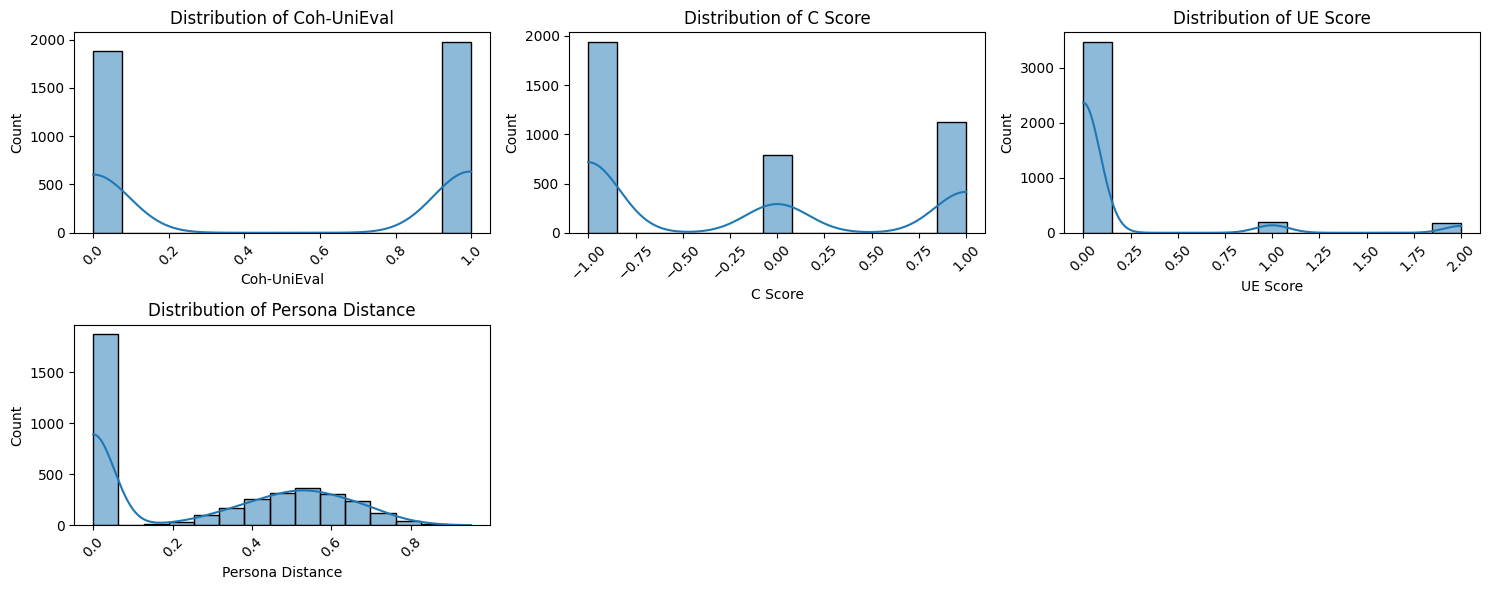

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_analyze = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

plt.figure(figsize=(15, 5*len(columns_to_analyze)//3))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(len(columns_to_analyze)//3 + 1, 3, i)
    sns.histplot(data= df, x=column, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Step 2: Normalize metrics to [0, 1]
metrics = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

scaler = MinMaxScaler()
df[metrics] = scaler.fit_transform(df[metrics])

# Compute response length in number of words
df.rename(columns={"gen_response": "response"}, inplace=True)

df["response_length"] = df["response"].str.split().str.len()

# Set your preferred maximum response length
if _COT == "-COT":
    MAX_LEN = 220
else:
    MAX_LEN = 110

# Compute length penalty (shorter is better)
df["length_penalty"] = 1.0 - (df["response_length"] / MAX_LEN)
df["length_penalty"] = df["length_penalty"].clip(lower=0.0, upper=1.0)


if SCORING_METHOD == "AVG":
    
    # AVG Style
    df["quality_score"] = df[metrics].mean(axis=1)
else:
    
    # Prioritizing the Response Length
    df["quality_score"] = (
        0.15 * df["Coh-UniEval"] +
        0.15 * df["C Score"] +
        0.15 * df["UE Score"] +
        0.15 * df["Persona Distance"] + 
        0.4 * df["length_penalty"]
    )

print("✅ Added normalized quality score:")
display(df[["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "length_penalty", "quality_score"]].head())

df.drop(columns=["Coh-UniEval", "C Score", "UE Score", "Persona Distance", "length_penalty"], inplace=True)

df.drop(columns=["act_response", "response_time", "response_length"], inplace=True)

✅ Added normalized quality score:


,Coh-UniEval,C Score,UE Score,Persona Distance,length_penalty,quality_score
0,0.999586,0.5,1.0,0.251280,0.345455,0.687717
1,0.997956,1.0,1.0,0.362827,0.300000,0.840196
2,0.999742,1.0,1.0,0.682315,0.300000,0.920514
3,0.999050,1.0,1.0,0.736700,0.436364,0.933937
4,0.998437,1.0,0.5,0.481216,0.300000,0.744913


In [15]:
# Function to generate a prompt
def create_dpo_prompt(personas, context, _COT):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if _COT == "-COT":
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if _COT == "-COT":
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [16]:
# Step 4: Prepare prompt and extract unique pairs

# # Apply to your dataframe
# df["prompt"] = df.apply(lambda row: create_dpo_prompt(row["personas"], row["context"], _COT), axis=1)

df["prompt"] = df.apply(lambda row: f"Persona: {row['personas']}\nContext: {row['context']}", axis=1)

# Get unique (personas, context) pairs
unique_pairs = df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(unique_pairs)}")

df.head(3)


Total unique context-persona pairs: 2000


,personas,context,response,quality_score,prompt
0,I would like to visit Hawaiʻi.I am interested ...,"User1: Wow, this is amazing! What is this?\nUs...","The climate of Mauna Kea is tropical, with war...",0.687717,Persona: I would like to visit Hawaiʻi.I am in...
1,I live in baltimore.I am not from Maryland.I w...,"User1: I know this place, but I dont remember ...","This place, the Baltimore Convention Center, i...",0.840196,Persona: I live in baltimore.I am not from Mar...
2,I like libraries.I have never been to New York...,"User1: I know this place, but I dont remember ...","The Stephen A. Schwarzman Building, also known...",0.920514,Persona: I like libraries.I have never been to...


In [ ]:
# Step 5: Build DPO dataset with score-chosen and score-rejected
dpo_records = []

for _, pair in unique_pairs.iterrows():
    sub_df = df[
        (df["personas"] == pair["personas"]) &
        (df["context"] == pair["context"])
    ].sort_values("quality_score", ascending=False)
    
    if len(sub_df) >= 2:
        chosen_row = sub_df.iloc[0]
        rejected_row = sub_df.iloc[-1]
        
        dpo_records.append({
            "prompt": chosen_row["prompt"],
            "chosen": chosen_row["response"],
            "rejected": rejected_row["response"],
            "score_chosen": round(chosen_row["quality_score"], 4),
            "score_rejected": round(rejected_row["quality_score"], 4)
        })

print(f"Total DPO records prepared: {len(dpo_records)}")

Total DPO records prepared: 1855


In [ ]:
# Step 6: Final DataFrame
import pandas as pd

dpo_weighted_df = pd.DataFrame(dpo_records)

print(f"Final weighted DPO dataset shape: {dpo_weighted_df.shape}")

# Save weighted DPO dataset to CSV

if SCORING_METHOD == "AVG":
    output_path = f"dpo_avg{_COT}.csv"
else:
    output_path = f"dpo_length_prior{_COT}.csv"  

dpo_weighted_df.to_csv(f"dpo_datasets/{DATASET}_{output_path}", index=False)

print(f" File saved to: {output_path}")

dpo_weighted_df.head(30)

Final weighted DPO dataset shape: (1855, 5)
 File saved to: dpo_avg.csv


,prompt,chosen,rejected,score_chosen,score_rejected
0,Persona: I would like to visit Hawaiʻi.I am in...,"The climate of Mauna Kea is tropical, with war...",Please provide more details about your interes...,0.688,0.648
1,Persona: I live in baltimore.I am not from Mar...,"This place, the Baltimore Convention Center, i...",The Baltimore Convention Center is a large con...,0.840,0.811
2,Persona: I like libraries.I have never been to...,"The Stephen A. Schwarzman Building, also known...",The Stephen A. Schwarzman Building is a landma...,0.921,0.536
3,Persona: I like football.I have not been to Ne...,The SHI Stadium in New Jersey is where the Rut...,The SHI Stadium is located in New Jersey. It i...,0.934,0.650
4,Persona: I like military history.I have been t...,"Yes, the Old Melbourne Gaol has a rich history...","The Old Melbourne Gaol in Melbourne, Australia...",0.913,0.525
5,Persona: I hope to visit Oregon.I love to see ...,The Keller Fountain Park in Oregon is a beauti...,Keller Fountain Park is a beautiful park locat...,0.632,0.474
6,Persona: I’ve never been to Eagle County.I lov...,The Vail Ski Resort is located in the town of ...,The Vail Ski Resort is a great place to visit....,0.691,0.682
7,Persona: I have practice swimming for 7 years....,"This place, Centenary Pool Complex, is a speci...",The Centenary Pool Complex is a beautiful and ...,0.705,0.629
8,Persona: I have belief in Abraham.I have studi...,"Yes, the place is indeed religious for Palesti...",The location of the place is Hebron. It's a re...,0.889,0.638
9,Persona: I am interested in the history.I am i...,This place is significant because it showcases...,"The Richard Randall Art Studio is a small, sin...",0.591,0.576


# Dataset Concatination

In [19]:
BST = "Blended Skill Talk"
CONVAI = "IT-ConvAI2"
FOCUS = "FoCus"

_COT = ""
# _COT = "-COT"

# SCORING_METHOD = "avg"
SCORING_METHOD = "length_prior"

In [20]:
import pandas as pd

bst_df = pd.read_csv(f"dpo_datasets/{BST}_dpo_{SCORING_METHOD}.csv")
convai_df = pd.read_csv(f"dpo_datasets/{CONVAI}_dpo_{SCORING_METHOD}.csv")
focus_df = pd.read_csv(f"dpo_datasets/{FOCUS}_dpo_{SCORING_METHOD}.csv")

df = pd.concat([bst_df, convai_df], ignore_index=True) 
df.head(3)

,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,I'm sorry to hear that you experience anxiety....,I think it's because you're worried about how ...,0.711,0.116
1,I will provide you with a conversation context...,"Ha ha, that's hilarious! I can imagine my daug...","Oh no, that must've been quite a surprise! I'm...",0.645,0.564
2,I will provide you with a conversation context...,I'm glad to hear that! I can't wait for your s...,"I'm sure it's bittersweet for you, but it's gr...",0.690,0.530


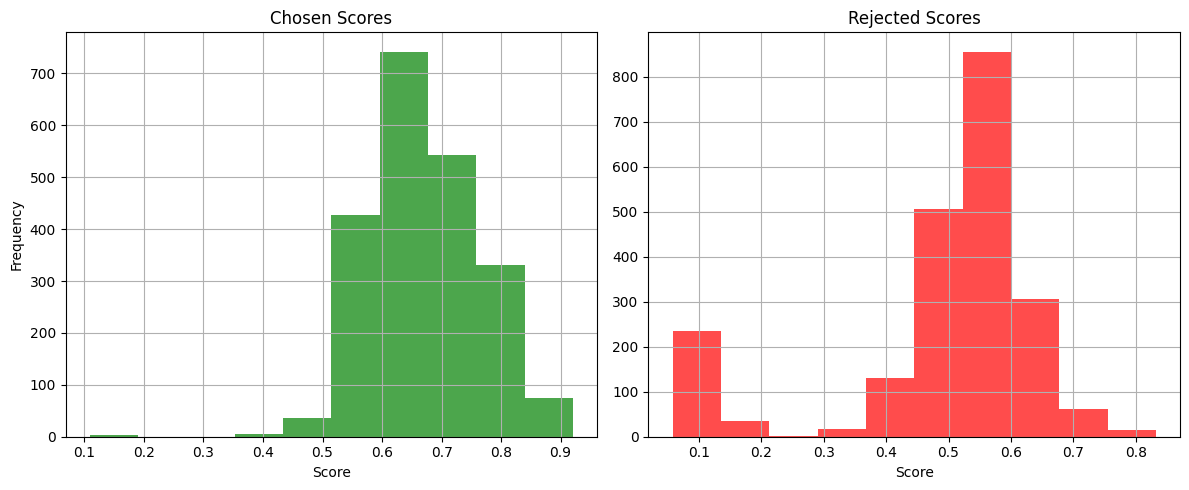

In [21]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms on each subplot
df.score_chosen.hist(ax=ax1, color='green', alpha=0.7)
ax1.set_title('Chosen Scores')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

df.score_rejected.hist(ax=ax2, color='red', alpha=0.7)
ax2.set_title('Rejected Scores')
ax2.set_xlabel('Score')

# Adjust layout and display
plt.tight_layout()
plt.show()


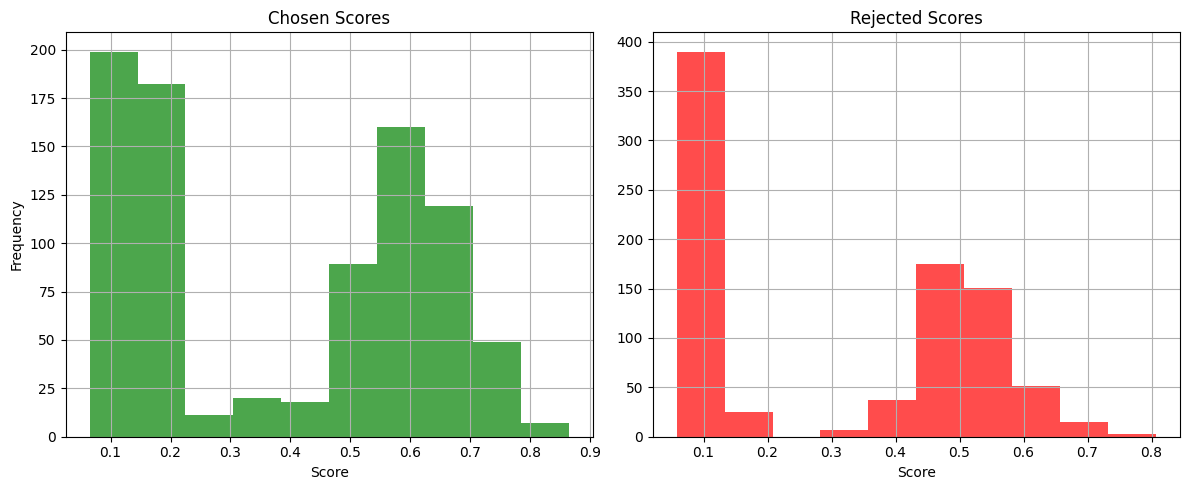

In [22]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms on each subplot
focus_df.score_chosen.hist(ax=ax1, color='green', alpha=0.7)
ax1.set_title('Chosen Scores')
ax1.set_xlabel('Score')
ax1.set_ylabel('Frequency')

focus_df.score_rejected.hist(ax=ax2, color='red', alpha=0.7)
ax2.set_title('Rejected Scores')
ax2.set_xlabel('Score')

# Adjust layout and display
plt.tight_layout()
plt.show()